In [1]:
import numpy as np
import pygtrie
from statsmodels.stats import multitest
import collections
import os
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib

import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
from scipy import stats

def read_tejaas(filename):
    rsidlist = list()
    bplist   = list()
    qscales = list()
    pvallist = list()
    qstatlist = list()
    qmeanlist = list()
    qstdlist = list()

    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            pval = float(linesplit[5])
            
            qstat = float(linesplit[2])
            qmean = float(linesplit[3])
            qstd  = float(linesplit[4])
            
            rsidlist.append(rsid)
            bplist.append(bppos)
            qstatlist.append(qstat)
            qmeanlist.append(qmean)
            qstdlist.append(qstd)
            pvallist.append(pval)

    #pvalarr = 2.0 * (1 - stats.norm.cdf(np.abs(qscales)))
    #pvalarr = 1 - stats.norm.cdf(np.array(qscales))
    #pvallist = [x for x in pvalarr]
    return rsidlist, bplist, pvallist, qstatlist, qmeanlist, qstdlist

In [3]:
resdir = "/cbscratch/franco/trans-eqtl/dev-pipeline/randomizations/norm"
tissue = "gtex-ms"
chrm = 7
niter = 999

#gwrsids = list()
#gwpvals = list()
#gwnsnps = dict()
#gwbppos = dict()
gwqstat = list()
gwqmean = list()
gwqstds = list()
for rand in range(1, niter + 1):
    chrdir = "chr{:d}".format(chrm)
    srcdir = os.path.join(resdir, tissue)
    rrfile = os.path.join(srcdir, 'tejaas_rand_{:d}/permnull_sb0.05/{:s}/chunk000_rr.txt'.format(rand, chrdir))
    rsids, bplist, pvals, qstats, qmeans, qstds = read_tejaas(rrfile)
    #gwrsids += rsids
    #gwpvals += pvals
    gwqstat += qstats
    gwqmean += qmeans
    gwqstds += qstds
    #gwnsnps[chrm] = len(rsids)
    #gwbppos[chrm] = np.array(bplist)

In [44]:
resdir = "/cbscratch/franco/trans-eqtl/dev-pipeline/randomizations/lmcorrected_age"
tissue = "gtex-ms"
chrm = 7

#gwrsids2 = list()
#gwpvals2 = list()
#gwnsnps2 = dict()
#gwbppos2 = dict()
gwqstat2 = list()
gwqmean2 = list()
gwqstds2 = list()
for rand in range(1, 1000):
    chrdir = "chr{:d}".format(chrm)
    srcdir = os.path.join(resdir, tissue)
    rrfile = os.path.join(srcdir, 'tejaas_rand_{:d}/permnull_sb0.05/{:s}/chunk000_rr.txt'.format(rand, chrdir))
    rsids, bplist, pvals, qstats, qmeans, qstds = read_tejaas(rrfile)
    #gwrsids2 += rsids
    #gwpvals2 += pvals
    gwqstat2 += qstats
    gwqmean2 += qmeans
    gwqstds2 += qstds
    #gwnsnps2[chrm] = len(rsids)
    #gwbppos2[chrm] = np.array(bplist)

In [5]:
# gwpvals = np.array(gwpvals)
# pmin  = np.min(gwpvals[np.where(gwpvals > 0)])
# nonzero_pvals = gwpvals.copy()
# nonzero_pvals[np.where(gwpvals == 0)] = pmin
# gwlogpvals = -np.log10(nonzero_pvals)

gwqstat = np.array(gwqstat)
gwqmean = np.array(gwqmean)
gwqstds = np.array(gwqstds)

In [45]:
# gwpvals2 = np.array(gwpvals2)
# pmax  = np.min(gwpvals2[np.where(gwpvals2 > 0)])
# nonzero_pvals = gwpvals2.copy()
# nonzero_pvals[np.where(gwpvals2 == 0)] = pmin
# gwlogpvals2 = -np.log10(nonzero_pvals)

gwqstat2 = np.array(gwqstat2)
gwqmean2 = np.array(gwqmean2)
gwqstds2 = np.array(gwqstds2)

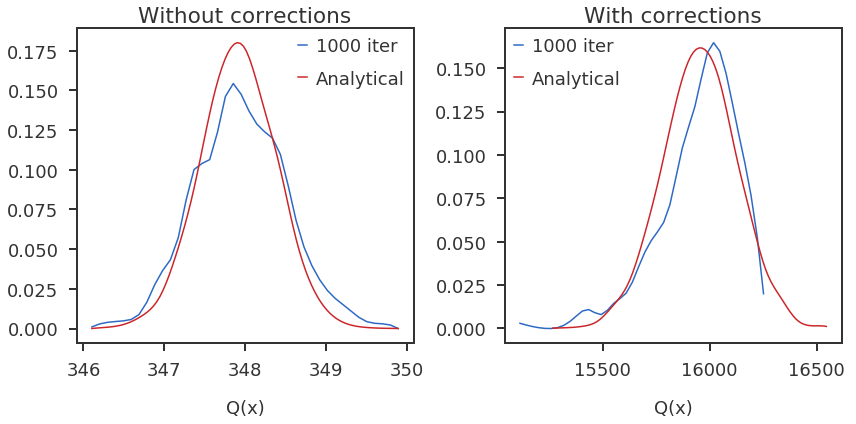

In [80]:
from scipy.interpolate import interp1d


fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nsnps = int(gwqstat.shape[0] / niter)
snpid = 12

nchoose = np.array([nsnps * i + snpid for i in range(niter)])
qiter = gwqstat[nchoose]

xmax = np.around(np.max(qiter))
xmin = np.around(np.min(qiter))
bins = np.linspace(xmin, xmax, 20)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 40)
yhist, _ = np.histogram(qiter, bins = bins)
yfreq = yhist / len(qiter)
fy = interp1d(xbin, yfreq, kind = 'cubic')
y = fy(x)
ax1.plot(x, y, alpha = 1, label = '1000 iter')

qmean = np.mean(gwqmean[nchoose])
qstd  = np.mean(gwqstds[nchoose])
qiter = np.random.normal(qmean, qstd, size = 10000)

xmax = np.around(np.max(qiter), decimals = 0)
xmin = np.around(np.min(qiter), decimals = 0)
bins = np.linspace(xmin, xmax, 20)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 100)
yhist, _ = np.histogram(qiter, bins = bins)
yfreq = yhist / len(qiter)
fy = interp1d(xbin, yfreq, kind = 'cubic')
y = fy(x)
ax1.plot(x, y, alpha = 1, label = 'Analytical')

nchoose = np.array([nsnps * i + snpid for i in range(niter)])
qmean = np.mean(gwqmean2[nchoose])
qstd  = np.mean(gwqstds2[nchoose])
alpha = qstd * qstd / 2.0 / qmean
chidf = qmean / alpha

qiter = gwqstat2[nchoose] / alpha

xmax = np.around(np.max(qiter))
xmin = np.around(np.min(qiter))
bins = np.linspace(xmin, xmax, 20)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 40)
yhist, _ = np.histogram(qiter, bins = bins)
yfreq = yhist / len(qiter)
fy = interp1d(xbin, yfreq, kind = 'cubic')
y = fy(x)
ax2.plot(x, y, alpha = 1, label = '1000 iter')

# qmean = np.mean(gwqmean2[nchoose])
# qstd  = np.mean(gwqstds2[nchoose])
# qiter = np.random.normal(qmean, qstd, size = 10000)

qiter = np.random.chisquare(chidf, size = 10000)

xmax = np.around(np.max(qiter), decimals = 0)
xmin = np.around(np.min(qiter), decimals = 0)
bins = np.linspace(xmin, xmax, 20)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 100)
yhist, _ = np.histogram(qiter, bins = bins)
yfreq = yhist / len(qiter)
fy = interp1d(xbin, yfreq, kind = 'cubic')
y = fy(x)
ax2.plot(x, y, alpha = 1, label = 'Analytical')


ax1.set_xlabel('Q(x)')
ax2.set_xlabel('Q(x)')
ax1.legend()
ax2.legend()
ax1.set_title('Without corrections')
ax2.set_title ('With corrections')

plt.tight_layout()
plt.show()

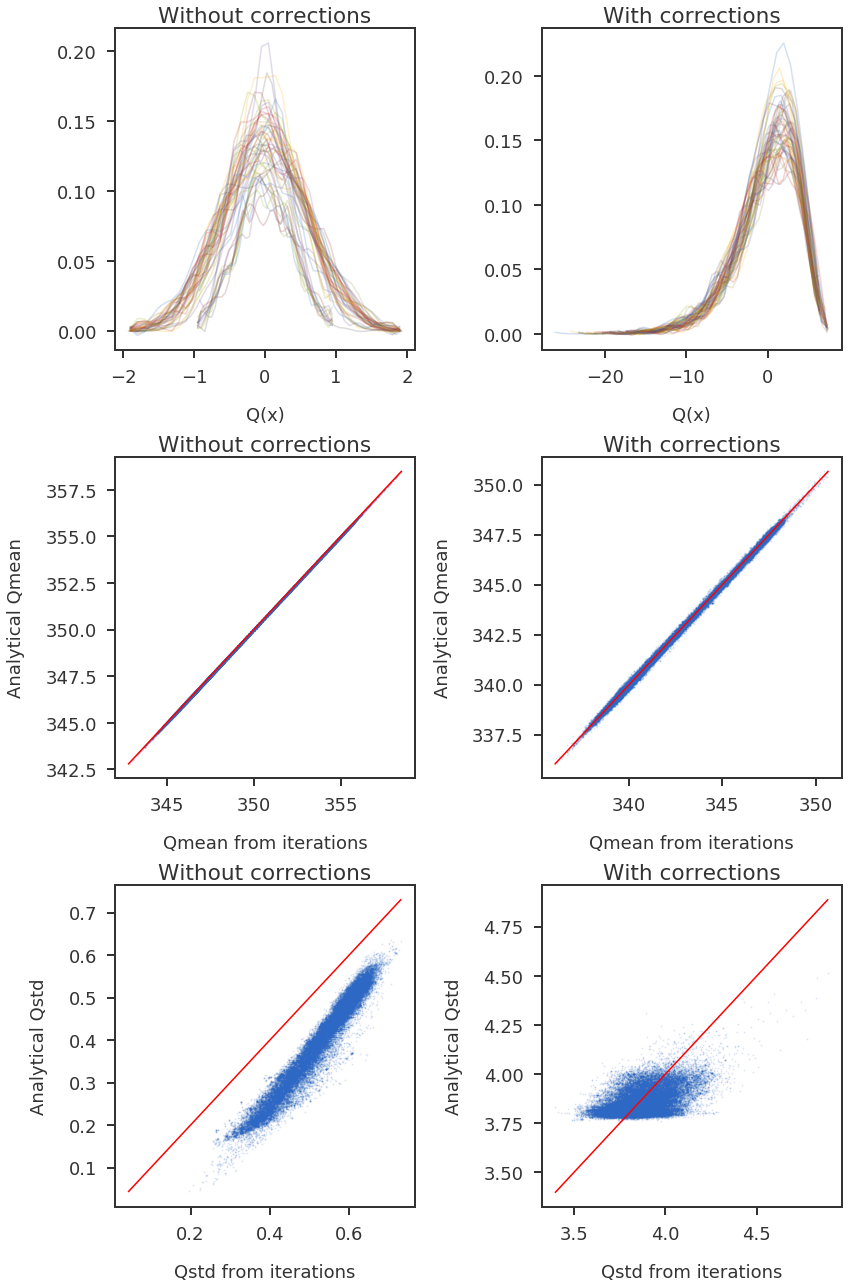

In [81]:
from scipy.interpolate import interp1d


fig = plt.figure(figsize = (12, 18))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326) 

nsnps = int(gwqstat.shape[0] / niter)


snpid_arr = np.random.choice(nsnps, size = 50, replace = False)

for snpid in snpid_arr:
    nchoose = np.array([nsnps * i + snpid for i in range(niter)])
    qiter = gwqstat[nchoose] - np.mean(gwqstat[nchoose])

    xmax = np.around(np.max(qiter))
    xmin = np.around(np.min(qiter))
    bins = np.linspace(xmin, xmax, 20)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 40)
    yhist, _ = np.histogram(qiter, bins = bins)
    yfreq = yhist / len(qiter)
    fy = interp1d(xbin, yfreq, kind = 'cubic')
    y = fy(x)
    ax1.plot(x, y, alpha = 0.2)


    qiter = gwqstat2[nchoose] - np.mean(gwqstat2[nchoose])

    xmax = np.around(np.max(qiter))
    xmin = np.around(np.min(qiter))
    bins = np.linspace(xmin, xmax, 20)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 40)
    yhist, _ = np.histogram(qiter, bins = bins)
    yfreq = yhist / len(qiter)
    fy = interp1d(xbin, yfreq, kind = 'cubic')
    y = fy(x)
    ax2.plot(x, y, alpha = 0.2)

iterations_mean = list()
analytical_mean = list()
iterations_std = list()
analytical_std = list()
iterations_mean_corr = list()
analytical_mean_corr = list()
iterations_std_corr = list()
analytical_std_corr = list()

for snpid in range(nsnps):
    nchoose = np.array([nsnps * i + snpid for i in range(niter)])
    qiter = gwqstat[nchoose]
    iterations_mean.append(np.mean(qiter))
    iterations_std.append(np.std(qiter))
    analytical_mean.append(np.mean(gwqmean[nchoose]))
    analytical_std.append(np.mean(gwqstds[nchoose]))

    qiter = gwqstat2[nchoose]
    iterations_mean_corr.append(np.mean(qiter))
    iterations_std_corr.append(np.std(qiter))
    analytical_mean_corr.append(np.mean(gwqmean2[nchoose]))
    analytical_std_corr.append(np.mean(gwqstds2[nchoose]))
#     analytical_mean_corr.append(gwqmean2[snpid])
#     analytical_std_corr.append(gwqstds2[snpid])
    

ax3.scatter(iterations_mean, analytical_mean, s = 1, alpha = 0.1)
ax5.scatter(iterations_std, analytical_std, s = 1, alpha = 0.1)
ax4.scatter(iterations_mean_corr, analytical_mean_corr, s = 1, alpha = 0.1)
ax6.scatter(iterations_std_corr, analytical_std_corr, s = 1, alpha = 0.1)

xmin = min(iterations_mean + analytical_mean)
xmax = max(iterations_mean + analytical_mean)
ax3.plot([xmin, xmax], [xmin, xmax], color = 'red')

xmin = min(iterations_std + analytical_std)
xmax = max(iterations_std + analytical_std)
ax5.plot([xmin, xmax], [xmin, xmax], color = 'red')

xmin = min(iterations_mean_corr + analytical_mean_corr)
xmax = max(iterations_mean_corr + analytical_mean_corr)
ax4.plot([xmin, xmax], [xmin, xmax], color = 'red')

xmin = min(iterations_std_corr + analytical_std_corr)
xmax = max(iterations_std_corr + analytical_std_corr)
ax6.plot([xmin, xmax], [xmin, xmax], color = 'red')

ax1.set_xlabel('Q(x)')
ax2.set_xlabel('Q(x)')
ax3.set_xlabel('Qmean from iterations')
ax3.set_ylabel('Analytical Qmean')
ax5.set_xlabel('Qstd from iterations')
ax5.set_ylabel('Analytical Qstd')

ax4.set_xlabel('Qmean from iterations')
ax4.set_ylabel('Analytical Qmean')
ax6.set_xlabel('Qstd from iterations')
ax6.set_ylabel('Analytical Qstd')
#ax1.legend()
#ax2.legend()
ax1.set_title('Without corrections')
ax3.set_title('Without corrections')
ax5.set_title('Without corrections')
ax2.set_title ('With corrections')
ax4.set_title ('With corrections')
ax6.set_title ('With corrections')


plt.tight_layout()
plt.show()

In [65]:
min(iterations_std + analytical_std)

0.044993